### Human in loop

In [1]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq

In [2]:
llm = ChatGroq(model="Gemma2-9b-it")

In [3]:

@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [4]:
multiply.invoke({"first_number":4,"second_number":2})

8

In [5]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [6]:
search("first prime minister of india")

C:\Users\kmrsu\AppData\Local\Temp\ipykernel_20488\4117398075.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  search("first prime minister of india")


[{'title': 'List of prime ministers of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/List_of_prime_ministers_of_India',
  'content': "Since 1947, India has had 14 prime ministers.[a] Jawaharlal Nehru was India's first prime minister, serving as prime minister of the Dominion of India from 15 August 1947 until 26 January 1950, and thereafter of the Republic of India until his death in May 1964. (India conducted its first post-independence general elections in 1952). Earlier, Nehru had served as prime minister of the Interim Government of India during the British Raj from 2 September 1946 until 14 August 1947, his party, the [...] Top left: Jawaharlal Nehru was the first and the longest-serving prime minister in Indian history.\nTop center: Indira Gandhi was the first and only woman to serve as prime minister.\nTop right: Charan Singh was the first and only prime minister in Indian history who never faced parliament.\nBottom left: Atal Bihari Vajpayee was the first non-Cong

In [7]:
tools=[search,multiply]

llm_with_tools = llm.bind_tools(tools)


In [8]:
tool_mapping = {tool.name:tool for tool in tools}

In [9]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000182BD6DE660>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000182BD6DDBC0>)}

In [10]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [11]:
def agent(state:AgentState):
    question = state['messages']
    message = question[-1]
    response = llm_with_tools.invoke(message)
    return {"messages":[response]}

In [12]:
def custom_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [13]:
def router(state):
    messsage = state["messages"]
    if messsage[-1].tool_calls:
        return "tool"
    else:
        return "end"

In [14]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent",agent)
graph_builder.add_node("tool",custom_tool)

graph_builder.add_edge(START,"agent")
graph_builder.add_conditional_edges(
    "agent",
    router,
    {
        "tool":"tool",
        "end":END
    }
)
graph_builder.add_edge("tool",END)

graph = graph_builder.compile()


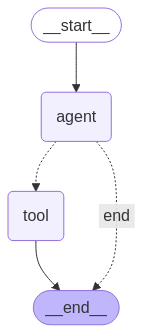

In [15]:
graph

In [16]:
for s in graph.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pyp3', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1075, 'total_tokens': 1158, 'completion_time': 0.150909091, 'prompt_time': 0.03771406, 'queue_time': 0.23571766900000002, 'total_time': 0.188623151}, 'model_name': 'Gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f80b316-d321-40f7-ad96-909c9f619881-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'call_pyp3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 83, 'total_tokens': 1158})]}
----
Selected tool: search
{'messages': [[{'title': '2024 United States presidential election - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/2024_United_States_presidential_election', 'content': "

### Human in loop interupt method

In [17]:
llm = ChatGroq(model="Gemma2-9b-it")

In [18]:
tavily=TavilySearchResults()
tools = [tavily]
llm_with_tools = llm.bind_tools(tools)

In [19]:
from langgraph.graph import MessagesState
def chatbot(state:MessagesState):
    meassage = state["messages"]
    response = llm_with_tools.invoke(meassage)
    return {"messages":[response]}

In [30]:
from langgraph.checkpoint.memory import MemorySaver
workflow = StateGraph(MessagesState)

workflow.add_node("agent",chatbot)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",tools_condition)
workflow.add_edge("tools","agent")


memory = MemorySaver()
app = workflow.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
    )

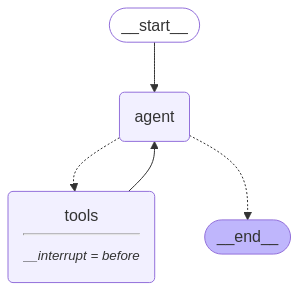

In [31]:
app

In [47]:

user_input = "who is the CEO of Google"
config = {"configurable": {"thread_id": "1"}}

events = app.stream({"messages": [("user", user_input)]}, config, stream_mode="values")

In [48]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

who is the CEO of Google
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jw1v)
 Call ID: call_jw1v
  Args:
    query: Who is the CEO of Google?


In [49]:
events = app.stream(None, config, stream_mode="values")

In [50]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jw1v)
 Call ID: call_jw1v
  Args:
    query: Who is the CEO of Google?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Sundar Pichai - Wikipedia", "url": "https://en.wikipedia.org/wiki/Sundar_Pichai", "content": "Title   CEO of Alphabet and Google\nBoard member of \nAlphabet Inc.[1]\nMagic Leap (2014–2018)[2]\nSpouse  Anjali Pichai\nChildren    2\nAwards  Padma Bhushan (2022)\nSundar Pichai's voice\nPichai on being chief executive officer of Google\nRecorded December 11, 2018\nSignature\nPichai Sundararajan (born June 10, 1972), better known as Sundar Pichai,[a] is an American business executive.[3][4] He is the chief executive officer of Alphabet Inc. and its subsidiary Google.[5] [...] Pichai was selected to become the next CEO of Google on August 10, 2015, after previously being 